# 멋진 작사가 만들기
## 1. 데이터 다운로드
[여기](https://www.kaggle.com/paultimothymooney/poetry/data)에서 Song Lyrics 데이터를 다운로드한다. 저장된 파일을 압축 해제한 후, 모든 txt 파일을 lyrics 폴더를 만들어 그 속에 저장한다. 

또는 터미널에서 아래의 명령어를 실행한다.
```python
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/song_lyrics.zip
$ unzip song_lyrics.zip -d ~/aiffel/lyricist/data/lyrics  
#lyrics 폴더에 압축풀기
```

## 2. 데이터 읽어오기
glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장한다.

In [1]:
import re                  # 정규표현식을 위한 Regex 지원 모듈 (문장 데이터를 정돈하기 위해) 
import numpy as np         # 변환된 문장 데이터(행렬)을 편하게 처리하기 위해
import tensorflow as tf 
import glob
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담는다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()  # 텍스트를 라인 단위로 끊어서 list 형태로 읽기
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:9]) # 앞에서부터 10라인만 화면에 출력

데이터 크기: 187088
Examples:
 ['They say get ready for the revolution', "I think it's time we find some sorta solution", "Somebody's caught up in the endless pollution", 'They need to wake up, stop living illusions I know you need to hear this', "Why won't somebody feel this", 'This is my wish that we all feel connected', 'This is my wish that nobodies neglected Be like a rocket baby', 'Be like a rocket Take off', 'Just fly, away (ay, ay)']


## 3. 데이터 정제
데이터의 형태를 보고 1차 필터링을 하였다. 길이가 0인 문장과 문장의 끝이 ":"인 문장을 제외시키고 10개의 문장을 출력하였다.

In [2]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue # 길이가 0인 문장은 건너뛴다.
    if sentence[-1] == ":": continue  # 문장의 끝이 ":"인 문장은 건너뛴다.
    if idx > 9: break   # 일단 문장 10개만 확인해 본다.
        
    print(sentence)

They say get ready for the revolution
I think it's time we find some sorta solution
Somebody's caught up in the endless pollution
They need to wake up, stop living illusions I know you need to hear this
Why won't somebody feel this
This is my wish that we all feel connected
This is my wish that nobodies neglected Be like a rocket baby
Be like a rocket Take off
Just fly, away (ay, ay)
To find your space Take off


단어 사전을 만들기 위해서 문장을 일정한 기준으로 나누는 토큰화를 한다. preprocess_sentence() 함수를 만들어 띄어쓰기를 기준으로 문장을 나누고, 다음과 같은 방식으로 데이터를 전처리 한다. 

1. 문장부호 양쪽으로 공백을 추가한다.     
2. 대문자를 소문자로 바꾼다.     
3. 특수문자를 모두 제거한다.       

언어 모델의 입력 문장 :  \<start> 나는 밥을 먹었다     
언어 모델의 출력 문장 : 나는 밥을 먹었다 \<end>     
    
또한 위와 같이 데이터 셋을 만들기 위해 문장의 앞과 뒤에 \<start>와 \<end>를 추가하였다. 

In [3]:
# 전처리, 정규표현식(Regex)을 이용한 필터링 사용
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       # 소문자로 바꾸고 양쪽 공백을 삭제
  
    # 아래 3단계를 거쳐 sentence는 스페이스 1개를 delimeter로 하는 소문자 단어 시퀀스로 바뀜
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                  # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)  # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'      # 문장 앞뒤로 <start>와 <end> 붙이기
    
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))   # 필터링 확인

<start> this is sample sentence . <end>


위의 정제 함수를 활용하여 정제 데이터를 구축한다. 

In [4]:
# 정제 함수를 사용한 정제 데이터 구축
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue

    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> they say get ready for the revolution <end>',
 '<start> i think it s time we find some sorta solution <end>',
 '<start> somebody s caught up in the endless pollution <end>',
 '<start> they need to wake up , stop living illusions i know you need to hear this <end>',
 '<start> why won t somebody feel this <end>',
 '<start> this is my wish that we all feel connected <end>',
 '<start> this is my wish that nobodies neglected be like a rocket baby <end>',
 '<start> be like a rocket take off <end>',
 '<start> just fly , away ay , ay <end>',
 '<start> to find your space take off <end>']

이제 문자로 이루어진 데이터를 인공지능이 이해할 수 있도록 숫자로 변환해야 한다.     

tf.keras.preprocessing.text.Tokenizer 패키지를 활용하여 정제된 데이터를 토큰화하고, 단어 사전을 만들고, 데이터를 숫자로 변환까지 해주는 벡터화를 한다. 

지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거한다. LMS에서 제시한 것처럼 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습데이터에서 제외하였다.

In [5]:
# 데이터를 숫자로 변환, 벡터화

def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가 가능. 이번에는 사용하지 않음
        oov_token="<unk>"  # out-of-vocabulary
    )
    tokenizer.fit_on_texts(corpus)   # 구축한 corpus로부터 Tokenizer가 사전을 자동구축한다.

    # tokenizer를 활용하여 모델에 입력할 데이터셋을 구축
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding 메소드를 제공
    # maxlen의 디폴트값인 None일 때, corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰진다.
    # 여기서는 15로 설정하여 토큰의 개수가 15개를 넘어가는 문장을 제외함. 
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen = 15, padding='post')  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

print(tensor[:3, :10])

[[  2  45  68 ...   0   0   0]
 [  2   5 126 ...   0   0   0]
 [  2 265  16 ...   0   0   0]
 ...
 [  2   5  61 ...   0   0   0]
 [124  73   5 ... 239  28   3]
 [  2   6 225 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7f683c206110>
[[   2   45   68   43  297   28    6 2109    3    0]
 [   2    5  126   11   16   73   23  204   99 3845]
 [   2  265   16  635   29   14    6 2963    1    3]]


텐서 데이터의 숫자는 tokenizer에 구축된 단어 사전의 인덱스이다. 단어 사전이 어떻게 구축되었는지 확인해 본다. 

In [6]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


생성된 텐서를 소스와 타겟으로 분리하여 모델이 학습할 수 있도록 한다. 여기서 0은 패딩문자 \<pad>이며, 정해진 입력 시퀀스 길이보다 문장이 짧을 경우 패딩으로 채워 넣은 것이다. 

In [7]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성. 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높다.
tgt_input = tensor[:, 1:]    # tensor에서 <start>를 잘라내서 타겟 문장을 생성.

print(src_input[0])
print(tgt_input[0])

[   2   45   68   43  297   28    6 2109    3    0    0    0    0    0]
[  45   68   43  297   28    6 2109    3    0    0    0    0    0    0]


## 4. 평가 데이터셋 분리
sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리한다. 단어장의 크기는 12,000으로 설정하고, 총 데이터의 20%를 평가 데이터셋으로 분리하였다.

Source Train: (124960, 14)            
Target Train: (124960, 14)

노드에서는 위와 같은 결과가 나오지 않는다면 데이터 정제 과정을 다시 해 보라고 하는데, 방법을 잘 모르겠다. 

In [8]:
# 훈련 데이터와 평가 데이터 분리
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input, 
                                                          test_size=0.2,  
                                                          shuffle=True)

print("Source Train:", enc_train.shape) 
print("Target Train:", dec_train.shape)

Source Train: (140599, 14)
Target Train: (140599, 14)


텐서플로우를 활용할 경우 텐서로 생성된 데이터를 이용해 tf.data.Dataset객체를 생성하는 방법을 흔히 사용한다. 데이터셋을 텐서 형태로 생성하였기 때문에 tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성한다. 훈련 데이터와 평가 데이터를 각각 tf.data.Dataset객체로 생성하였다.

이 부분은 이해가 잘 가지 않아 조원의 도움으로 해결하였다.

In [9]:
# tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체 생성
# 학습 데이터
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1    # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개

dataset1 = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
dataset1 = dataset1.batch(BATCH_SIZE, drop_remainder=True)
dataset1

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

In [10]:
# tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체 생성
# 평가 데이터
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1    # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개

dataset2 = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
dataset2 = dataset2.batch(BATCH_SIZE, drop_remainder=True)
dataset2

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

## 5. 인공지능 만들기
모델은 tf.keras.Model을 Subclassing하는 방식으로 만들 것이다. 모델은 1개의 Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.

> Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔 준다. 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용된다. embedding_size 는 워드 벡터의 차원수, 즉 단어가 추상적으로 표현되는 크기이다. 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만, 충분한 데이터가 주어지지 않으면 오히려 혼란만을 야기할 수 있다. 

> LSTM 레이어의 hidden state 의 차원수인 hidden_size는 모델에 얼마나 많은 일꾼을 둘 것인가? 로 이해해도 된다. 그 일꾼들은 모두 같은 데이터를 보고 각자의 생각을 가지는데, 충분한 데이터가 주어지면 올바른 결정을 내리지만 그렇지 않으면 배가 산으로 간다.

위의 설명을 참고하여 모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있도록 모델을 설계하였다.

In [11]:
# tf.keras.Model을 Subclassing하는 방식으로 모델 만들기
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) # 단어 사전의 인덱스값->인덱스 번째의 워드 벡터
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

설계한 모델에 데이터를 넣어 확인해 본다. 모델의 최종 출력 텐서 shape=(256, 14, 12001)이다. 12001은 Dense 레이어의 출력 차원수이며, 12001개의 단어 중 어느 단어의 확률이 가장 높을지를 모델링한다. 256은 지정한 배치 사이즈이고, dataset.take(1)를 통해서 1개의 배치, 즉 256개의 문장 데이터를 가져온 것이다.

LSTM 레이어에서 return_sequences=True의 뜻은 LSTM은 자신에게 입력된 시퀀스의 길이만큼 동일한 길이의 시퀀스를 출력한다는 의미이다. 데이터셋의 max_len이 15이므로 길이 15의 문장을 출력한다. 

In [12]:
# 훈련 데이터의 문장
for src_sample, tgt_sample in dataset1.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 1.33403722e-04,  1.27855950e-04,  1.60429350e-04, ...,
          9.37719524e-05,  1.52588356e-04,  6.07635548e-06],
        [ 2.15726046e-04,  3.80283804e-04,  2.20275702e-04, ...,
         -1.39630181e-04,  3.19607818e-04,  3.66073909e-05],
        [ 4.14136011e-04,  2.91649223e-04,  2.40194655e-04, ...,
         -5.22263465e-04,  6.97071955e-04,  8.39797649e-05],
        ...,
        [ 3.75354837e-04,  1.74196233e-04, -2.74455106e-05, ...,
         -4.26990911e-04,  4.61092015e-04, -1.00597576e-03],
        [ 2.36141161e-04,  6.89809560e-04,  7.99637928e-05, ...,
         -4.09715372e-04,  3.91217152e-04, -9.69381304e-04],
        [-1.08435794e-04,  9.07401904e-04,  3.38523969e-04, ...,
         -1.44875696e-04,  5.23680879e-04, -7.57600938e-04]],

       [[ 1.33403722e-04,  1.27855950e-04,  1.60429350e-04, ...,
          9.37719524e-05,  1.52588356e-04,  6.07635548e-06],
        [ 2.28188670e-04,  2.33416751e-04,  1

In [13]:
# 평가 데이터의 문장
for src_sample, tgt_sample in dataset2.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[ 1.3340372e-04,  1.2785595e-04,  1.6042935e-04, ...,
          9.3771952e-05,  1.5258836e-04,  6.0763555e-06],
        [-6.9560818e-05,  2.6105670e-04,  1.3569099e-04, ...,
          2.4479377e-04,  7.9330523e-05,  1.8231356e-05],
        [-4.9915659e-05,  3.7813213e-04,  5.8374644e-05, ...,
          2.6723661e-04,  4.7734444e-05,  2.4334100e-04],
        ...,
        [-5.3605105e-04, -7.9727601e-05, -1.8469099e-04, ...,
          1.7451844e-03,  3.1911273e-04,  3.6636618e-04],
        [-5.7039224e-04, -2.2827552e-04,  4.3931641e-04, ...,
          1.5137453e-03,  5.9463142e-04,  2.0706627e-04],
        [-6.1125628e-04, -3.4796022e-04,  1.0443634e-03, ...,
          1.2726050e-03,  8.3594111e-04,  1.9916266e-05]],

       [[ 1.3340372e-04,  1.2785595e-04,  1.6042935e-04, ...,
          9.3771952e-05,  1.5258836e-04,  6.0763555e-06],
        [ 9.9955585e-05,  3.7408431e-04,  1.4047005e-04, ...,
          2.2956016e-04, 

위에서 설계한 모델은 입력 시퀀스의 길이를 모르므로 Output Shape를 알 수 없으나 모델의 파라미터 사이즈는 측정된다.

In [14]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  18882560  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  24590049  
Total params: 80,107,489
Trainable params: 80,107,489
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 학습

history = []
epochs = 10
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)



history = model.fit(dataset1,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=dataset2,
                    verbose=1)

Epoch 1/10
549/549 [==============================] - 212s 386ms/step - loss: 3.6320 - val_loss: 3.2275
Epoch 2/10
549/549 [==============================] - 216s 394ms/step - loss: 3.0565 - val_loss: 2.9677
Epoch 3/10
549/549 [==============================] - 217s 395ms/step - loss: 2.7775 - val_loss: 2.7736
Epoch 4/10
549/549 [==============================] - 218s 396ms/step - loss: 2.5216 - val_loss: 2.6390
Epoch 5/10
549/549 [==============================] - 242s 442ms/step - loss: 2.2733 - val_loss: 2.5319
Epoch 6/10
549/549 [==============================] - 247s 450ms/step - loss: 2.0351 - val_loss: 2.4479
Epoch 7/10
549/549 [==============================] - 245s 446ms/step - loss: 1.8092 - val_loss: 2.3892
Epoch 8/10
549/549 [==============================] - 217s 396ms/step - loss: 1.6027 - val_loss: 2.3472
Epoch 9/10
549/549 [==============================] - 217s 395ms/step - loss: 1.4218 - val_loss: 2.3250
Epoch 10/10
549/549 [==============================] - 213s 389m

학습 결과를 그래프로 그려 보았다. Loss가 점점 떨어지는 것을 볼 수 있다. 

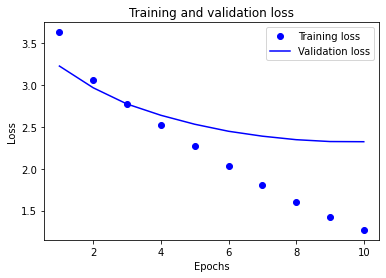

In [16]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# training loss: "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# validation loss: "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행하게 하는 generate_text 함수를 만들었다. 텍스트를 생성해야 하는데, 타겟 문장과 소스 문장이 없고, 테스트 데이터셋을 생성하지 않았기 때문에 while문을 써서 문장을 생성하게 된다.  

In [17]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됨 

        # 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙인다.
        test_tensor = tf.concat([test_tensor, 
                                    tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 최종적으로 모델이 생성한 자연어 문장

위의 함수를 사용하여 문장을 생성해 보았다. 

In [18]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love it when you call me big poppa <end> '

In [19]:
generate_text(model, tokenizer, init_sentence="<start> you are", max_len=20)

'<start> you are the one who grows distant <end> '

In [20]:
generate_text(model, tokenizer, init_sentence="<start> yesterday", max_len=20)

'<start> yesterday is coming to the usa sail on , sail on <end> '

## 루브릭 평가문항	
1. 가사 텍스트 생성 모델이 정상적으로 동작하는가?(텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?)     

다양한 단어로 문장을 시작하였을 때, 의미는 이상하지만 3 문장이 모두 그럴듯한 문장이 생성되었다. 

2. 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?(특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?)

데이터 전처리(특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정)와 데이터셋 구성 과정은 체계적으로 진행되었다. 

3. 텍스트 생성모델이 안정적으로 학습되었는가?(텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?)       
모델의 Embedding Size와 Hidden Size를 변경해 가며 validation loss를 2.2 이하로 낮추려고 시도하였으나 2.2 이하로 내려가지 않았다. 

## 후기
### 이번 프로젝트에서 어려웠던 점
- 모델 성능 개선      
Embedding Size와 Hidden Size를 다양하게 조절하여 텍스트 생성 모델의 validation loss를 2.2 이하로 내려가려고 시도하였으나 결국 2.2 이하로 낮추지 못하였다. 학습 시간이 오래 걸려서 파라미터를 더 많이 바꿀 수 없어서 아쉽다. 
- 텐서로 생성된 데이터를 tf.data.Dataset객체를 생성        
처음에는 데이터셋 분리를 객체 생성 다음에 했기 때문에 데이터셋 객체 생성이 왜 있어야 하는지 몰랐다. 조원들에게 질문을 하여 순서가 바뀌었다는 것을 깨달았다. 

### 프로젝트를 진행하면서 알게된 점
이번 프로젝트를 통해 이전까지는 무작정 따라하던 것들의 의미를 조금 알게 되었다. 토크나이저, 패딩, Embedding Size, LSTM의 Hidden Size 등의 개념이 노드에 나왔고, 이전에 배웠던 CS231n 강의에서도 배운 내용이 생각이 났기 때문이다. 아직 이해가 잘 되지 않는 부분도 있지만 조금이나마 이해할 수 있어서 기쁘다. 


### 프로젝트를 진행하면서 아직 모호한 점
텐서로 생성된 데이터를 tf.data.Dataset객체를 생성하는 부분이 사실 잘 이해가 가지 않는다. Wikidocs에서는 "모든 데이터세트는 tf.data.Datasets로 노출되므로 사용이 간편한 고성능 입력 파이프라인이 가능하다"라고 나와 있는데, 그 의미를 잘 모르겠다. 

### 자기 다짐
조원들이 자신들의 모델에 대해 잠시 설명해주는 시간이 있었다. 한 조원은 모델에 같은 레이어를 여러 개 쌓기도 하고, dropout 등 다른 것들을 쌓았다고 했다. 그러나 나는 아직까지 모델을 설계하는 방법을 잘 모르고 그 의미를 잘 모르겠다. 강의도 듣고 노드를 공부하지만 아직도 많이 부족한 것 같다. 또한 프로젝트를 하면서 쓰이는 코드도 혼자서는 쓰지 못하고, 의미도 제대로 이해하지 못하는 것 같다. 그래서 프로젝트를 하면서도 제대로 하고 있는건지 잘 모르겠고, 어떻게 공부해야 하는 건지 몰라 막막하다. 단지 프로젝트 제출하는 것에만 만족하기에는 뭔가 부족하다는 생각이 든다. 하지만 프로젝트의 모든 부분을 이해하기에는 체력이 잘 안 따라주고, 시간도 부족하다. 앞으로 어떻게 하면 좋을지에 대해서 생각해 봐야겠다. 